# Hourly Energy Demand Time Series Forecast

In this notebook we explore the various methods of forecasting in times series. Points covered in this notebook:
* Preprocessing the data
* Applying models and comparing their performance

This notebook is not exhaustive in presenting the methods for forecasting.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Loading Data and Taking a peek

**About the data:** This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here. 

The dataset is unique because it contains hourly data for electrical consumption and the respective forecasts by the TSO for consumption and pricing. **We focus on predicting electrical comsumption better than the already present forecast in the data. The metrics we are using for comparision is Mean Absolute Percentage Error or MAPE.**

The data is multivariate time series as it contains multiple features. To keep this notebook accessible to beginners, we use only a single feature thereby handling univariate time series. Although, to predict more accurately, most of the features presented in the data should be used and the problem should be handled as multivariate.

In [2]:
df = pd.read_csv("energy_dataset.csv")

In [3]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,6378.0000,17.0000,NaN,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,...,195.0000,0.0000,5890.0000,16.0000,NaN,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,5461.0000,8.0000,NaN,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,...,191.0000,0.0000,5238.0000,2.0000,NaN,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,...,189.0000,0.0000,4935.0000,9.0000,NaN,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
mape = np.mean(np.abs((df['total load actual'] - df['total load forecast']) / df['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.096023073723821


# Preprocessing

Here we extract the single feature we will predict, i.e. `total load actual`. Then we scale the feature using a MinMaxScaler. To prepare the data for the models, use `create_dataset` function which takes the data and creates chunks of it based on the `look_back`. 

The preprocessing works as follows:
Example data: `[1,2,3,4,5]`
After preprocessing (x -> y): 
>`[1,2]` -> `[3]` <br>
>`[2,3]` -> `[4]` <br>
>`[3,4]` -> `[5]` <br>

when `look_back` is set to 2. This preprocessing is only required for LSTM. Rest of the models take input as a series with single feature.

In [6]:
temp = df.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train, test = train_test_split(dataset, test_size=0.2, shuffle = False)
print(f'dataset shape: {dataset.shape}')

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

dataset shape: (35028, 1)
Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


# Models and their MAPE

Here we test various models and visualize their predictions. Models used are:
* AutoRegressive
* Moving Average
* ARMA
* ARIMA
* LSTM

## AutoRegressive

An autoregressive (AR) model predicts future behavior based on past behavior. The process is basically a linear regression of the data in the current series against one or more past values in the same series.

In [7]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()

In [8]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3729.264425078806
Test Root Mean Squared Error: 4391.073081234321


In [9]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 13.333375085466361


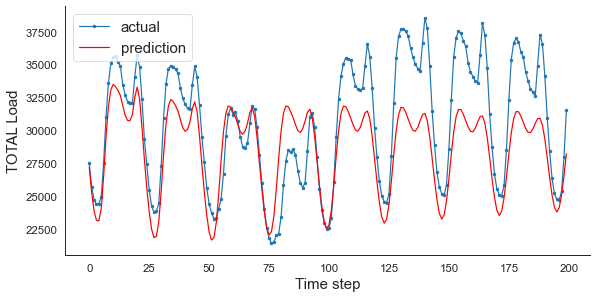

In [10]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Moving Average

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks or any time period the trader chooses. We are taking moving average of 25 hours hence we can use the data we prepared for LSTM.

In [11]:
test_predict = np.mean(X_test, axis=2)
print('Test Mean Absolute Error:', mean_absolute_error(testY, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY, test_predict)))

Test Mean Absolute Error: 0.14497761
Test Root Mean Squared Error: 0.17464507


In [12]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

ValueError: operands could not be broadcast together with shapes (7006,1) (6980,1) 

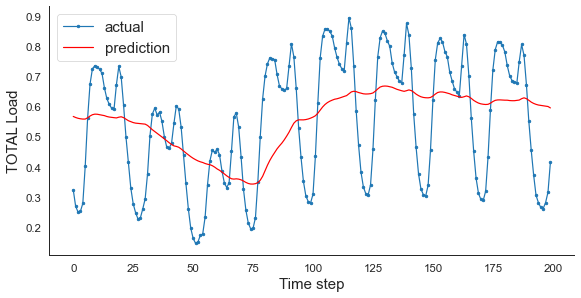

In [13]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## ARMA

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

In [14]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train, order=(2, 1))
model_fit = model.fit(disp=False)

In [ ]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

In [ ]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

In [ ]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## ARIMA

Auto Regressive Integrated Moving Average is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=False)

In [ ]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

In [ ]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

In [ ]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## LSTM

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data

In [ ]:
# making data again to remove inconsistencies
temp = df
dataset = temp['total load actual'].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## Analysis and Future Work

The LSTM model preformed close to the forecasted data present in the dataset. The MAPE can be improved further by forming this problem as a multivariate time series and tweaking the LSTM model. There are also many parameters that can improve the overall performance. The rest is upto your imagination!!